In [1]:
%matplotlib inline
#%load_ext autoreload
%load_ext lab_black

In [2]:
flow = "162-216"
runway = "14"
list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]
nb_features = len(list_features)
nb_samples = 64


def to_json_for_lab(data):
    output = to_json(data)
    output["url"] = os.path.join("files/", output["url"])
    return output

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from traffic.core import Traffic
from traffic.algorithms.clustering import prepare_features
from dcec.utils import input_shape
from traffic.data.datasets import landing_zurich_2019

t = (
    landing_zurich_2019.query("track == track")
    .resample(nb_samples)
    .unwrap("track")
    .eval(max_workers=10)
)
t.to_parquet(f"data/lszh_dcec.parquet")
X = prepare_features(t, None, list_features)
X = MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)
X = X.reshape(-1, *input_shape(nb_samples, nb_features))
np.save("data/lszh_dcec.npy", X)
X.shape

/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pkg_resources/__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/ipyleaflet/leaflet.py:317: DeprecationWarning: metadata {'dtype': None} was set from the constructor. With traitlets 4.1, metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  data = Dataset().tag(dtype=None, sync=True, to_json=ds_x_to_json)
Using TensorFlow backend.
/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pyarrow/pand

(19457, 8, 8, 4)

In [4]:
from time import time
import numpy as np
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model
from dcec.model import CAE

X = np.load("data/lszh_dcec.npy")

model = CAE(input_shape=X.shape[1:], filters=[32, 64, 2])
plot_model(
    model, to_file="dcec/pretrain-model.png", show_shapes=True,
)

# compile the model and callbacks
optimizer = "adam"
model.compile(optimizer=optimizer, loss="mse")
from keras.callbacks import CSVLogger

csv_logger = CSVLogger("dcec/pretrain-log.csv")

# begin training
t0 = time()
model.fit(X, X, verbose=0, batch_size=1000, epochs=100, callbacks=[csv_logger])
print("Training time: ", time() - t0)
model.save("dcec/pretrain-model.h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 4, 4, 32)          3232      
_________________________________________________________________
conv3 (Conv2D)               (None, 2, 2, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
embedding (Dense)            (None, 2)                 514       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               768       
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 64)          0         
_________________________________________________________________
deconv2 (Conv2DTranspose)    (None, 4, 4, 32)         

/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/keras/engine/training_utils.py:811: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(loss, collections.Mapping):


Training time:  33.61423063278198


feature shape= (19457, 2)


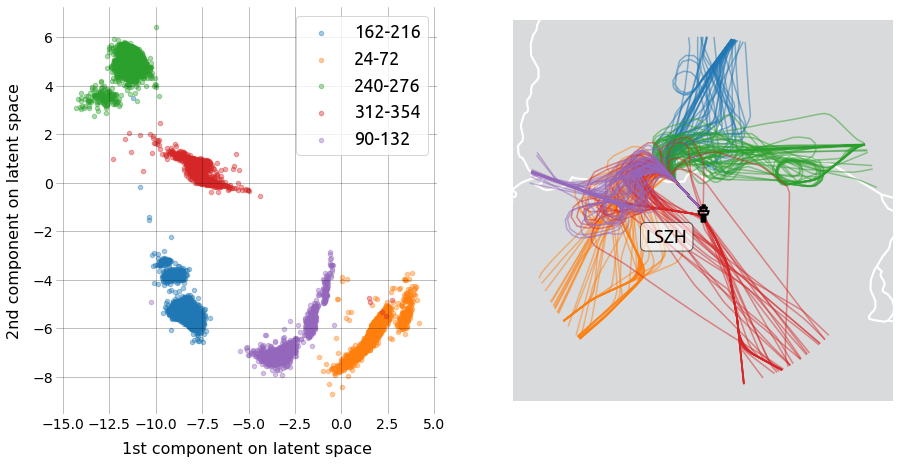

In [5]:
# extract features
from traffic.core import Traffic

feature_model = Model(
    inputs=model.input, outputs=model.get_layer(name="embedding").output
)
features = feature_model.predict(X)
print("feature shape=", features.shape)

from artefact.plot import plot_latent_and_trajs

t = Traffic.from_file(f"data/lszh_dcec.parquet")
plot_latent_and_trajs(t, features, f"figs/latent_dcec.png", runway=14)

In [6]:
from sklearn.preprocessing import MinMaxScaler
from traffic.core import Traffic
from dcec.clustering import DCEC
from dcec.utils import input_shape

t = Traffic.from_file(f"data/lszh_dcec.parquet")
list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]

nb_flights = len(t)
nb_samples = len(t[0])
nb_features = len(list_features)
print(f"nb_flights: {nb_flights}, nb_samples={nb_samples}")

dcec = DCEC(
    input_shape=input_shape(nb_samples, nb_features),
    filters=[32, 64, 2],
    n_clusters=4,
    alpha=1.0,
    batch_size=1000,
    epochs=1000,
    maxiter=1000,
    update_interval=140,
    cae_weights=None,
    save_dir="dcec",
)

t_c = t.clustering(
    nb_samples=None,
    features=list_features,
    clustering=dcec,
    transform=MinMaxScaler(feature_range=(-1, 1)),
).fit_predict()

t_c.groupby(["cluster"]).agg({"flight_id": "nunique"})

nb_flights: 19457, nb_samples=64
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 4, 4, 32)          3232      
_________________________________________________________________
conv3 (Conv2D)               (None, 2, 2, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
embedding (Dense)            (None, 2)                 514       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               768       
_________________________________________________________________
reshape_2 (Reshape)          (None, 2, 2, 64)          0         
_________________________________________________________________
deconv2 (Conv2DTransp

,flight_id
cluster,
0,8031
1,5271
2,2580
3,3575


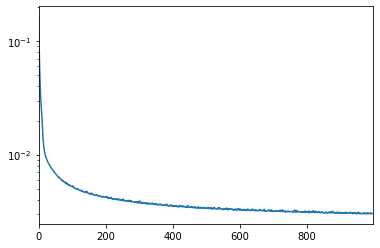

In [7]:
import pandas as pd

pd.read_csv("dcec/pretrain_log.csv").loss.plot(logy=True)

In [8]:
from dcec.utils import pretrained_clust

list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]

dcec, t_c = pretrained_clust(
    traffic_file="data/lszh_dcec.parquet",
    list_features=list_features,
    filters=[32, 64, 2],
    n_clusters=4,
    pretrained_path="dcec/dcec_model_final.h5",
    to_pickle=f"dcec/tc_dcec.pkl",
)

from artefact.plot import plot_latent_and_trajs

plot_latent_and_trajs(
    t_c,
    dcec.extract_feature(dcec.X),
    "dcec/latent_clusters.png",
    plot_clusters=True,
    runway=14,
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 4, 4, 32)          3232      
_________________________________________________________________
conv3 (Conv2D)               (None, 2, 2, 64)          18496     
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
embedding (Dense)            (None, 2)                 514       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               768       
_________________________________________________________________
reshape_3 (Reshape)          (None, 2, 2, 64)          0         
_________________________________________________________________
deconv2 (Conv2DTranspose)    (None, 4, 4, 32)         

AttributeError: 'tuple' object has no attribute 'reshape'

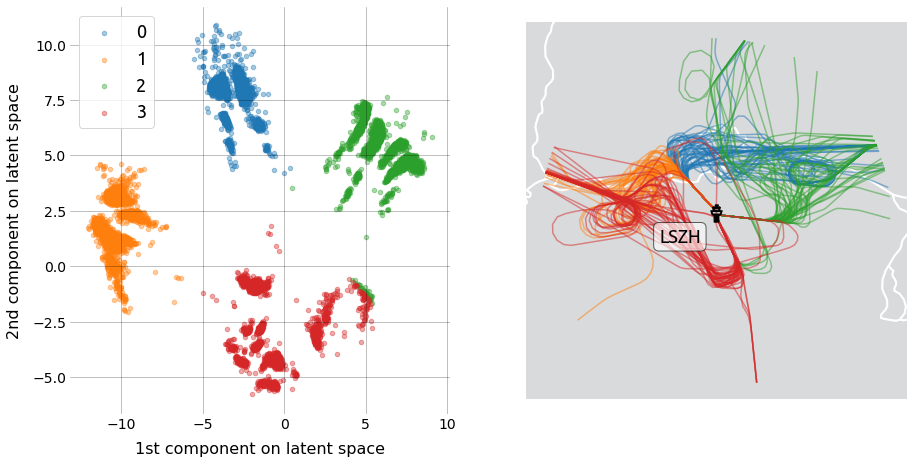

In [9]:
plot_latent_and_trajs(
    t_c,
    dcec.extract_feature(dcec.X),
    "dcec/latent_clusters_all_rnwys.png",
    plot_clusters=True,
    # runway=14,
)

In [10]:
from traffic.core import Traffic
from artefact.plot import plot_trajs

t_c = Traffic.from_file(f"dcec/tc_dcec.pkl")
plot_trajs(t_c, None)

FileNotFoundError: [Errno 2] No such file or directory: 'dcec/tc_dcec.pkl'

In [11]:
from traffic.core import Traffic
from artefact.utils import duration_cumdist_cluster

dur_dist = duration_cumdist_cluster(Traffic.from_file(f"dcec/tc_dcec.pkl"))
dur_dist

FileNotFoundError: [Errno 2] No such file or directory: 'dcec/tc_dcec.pkl'

In [12]:
from traffic.core import Traffic
from artefact.utils import duration_cumdist_flight
from artefact.plot import dur_dist_plot

t_c = Traffic.from_file(f"dcec/tc_dcec.pkl")
dur_dist = duration_cumdist_flight(t_c)

# hack to make altair work with json transformers in jupyterlab
import os
import altair as alt
from altair.utils.data import to_json
def to_json_for_lab(data):
    output = to_json(data)
    output["url"] = os.path.join("files/icrat", output["url"])
    return output

dur_dist_plot(dur_dist, to_json_for_lab)

FileNotFoundError: [Errno 2] No such file or directory: 'dcec/tc_dcec.pkl'

In [13]:
# outliers based on reconstruction error (re)
import numpy as np
from traffic.core import Traffic
from dcec.utils import pretrained_clust
from artefact.plot import plot_latent_and_trajs

list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]

dcec, t_c = pretrained_clust(
    traffic_file=f"data/lszh_dcec.parquet",
    list_features=list_features,
    filters=[32, 64, 2],
    n_clusters=4,
    pretrained_path="dcec/dcec_model_final.h5",
    to_pickle=f"dcec/tc_dcec.pkl",
)

re = t_c.data.re
threshold = np.percentile(re, 95)
outliers = Traffic.from_flights(
    f for f in t_c if f.data.re.mean() > threshold
)

print(len(outliers))
print(
    outliers.groupby(["cluster"]).agg(
        {"flight_id": "nunique", "re": ["mean", "min", "max"]}
    )
)

plot_latent_and_trajs(
    outliers,
    dcec.extract_feature(dcec.X),
    f"dcec/latent_clusters_outliers_re_dcec.png",
    plot_clusters=True,    
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 4, 4, 32)          3232      
_________________________________________________________________
conv3 (Conv2D)               (None, 2, 2, 64)          18496     
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
embedding (Dense)            (None, 2)                 514       
_________________________________________________________________
dense_4 (Dense)              (None, 256)               768       
_________________________________________________________________
reshape_4 (Reshape)          (None, 2, 2, 64)          0         
_________________________________________________________________
deconv2 (Conv2DTranspose)    (None, 4, 4, 32)         

AttributeError: 'tuple' object has no attribute 'reshape'

In [ ]:
from traffic.core import Traffic
from artefact.utils import duration_cumdist_flight
from artefact.plot import dur_dist_plot

dur_dist = duration_cumdist_flight(outliers)
dur_dist_plot(dur_dist)